In [58]:
import cv2             #opencv library used to extract color data from image
import numpy as np     #used for arrays
import keras           #we use ML models implemented in Keras
import glob            #regex library
import h5py            #file format to store dataset and weights
import tensorflow as tf
device_name=tf.test.gpu_device_name()   #check if GPU connected to runtime
print('Found GPU at: {}'.format(device_name))
import os
print(os.getcwd())
#!cat /proc/meminfo

Found GPU at: /device:GPU:0
/content


In [2]:
#Setting up and mounting Google Drive filesystem to Colab runtime so we can read image data
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls "drive/Colab"

dataset1	   dataset_genuine.h5  signature_recognition_softmax.ipynb
dataset2	   deepwriter.h5       signature_verification_siamese.ipynb
dataset4	   forged
dataset_forged.h5  genuine


In [59]:
#Create dataset (multidimensional arrays) from genuine signature images 
#This dataset (gen) is compiled by collecting all unique signatures across all 4 datasets (most dataset 3 and 4 'real' signature images)
from keras.utils import to_categorical
num_signers=44
gen=[]  #X component of dataset
y=[]    #Y component of dataset
genfilelist=[]
for i in range(44):
    for j in range(5):
        filename='drive/Colab/genuine/NFI-'+str(i+1).zfill(3)+str(j+1).zfill(2)+str(i+1).zfill(3)+'.png'
        genfilelist.append(filename)
        #print("genuine filename person ",i," signature ",j," = ",filename)
        img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap = cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)  #resize the image to manage the computational complexity in training
        pixelmap = np.expand_dims(pixelmap, axis=2) #to map it to ML model input
        pixelmap=pixelmap/255 #normalize the image data
        y.append(i)
        gen.append(np.asarray(pixelmap))
        
Ygen=to_categorical(y,num_signers)    
print (len(gen),len(Ygen))

print(Ygen[19].shape,gen[19].shape)

!rm 'drive/Colab/dataset_genuine.h5' 
hf = h5py.File('drive/Colab/dataset_genuine.h5', 'w') #store the dataset locally
hf.create_dataset('dataset_1', data=gen)
hf.create_dataset('dataset_2', data=Ygen)
hf.close()

(220, 220)
((44,), (150, 250, 1))


In [60]:
#Create dataset (multidimensional array) from forged signature images
#This dataset (forg) is compiled by collecting all unique signatures across all 4 datasets (most dataset 3 and 4 'real' signature images)
num_signers=44
forg=[]     #X component of training set
y=[]        #Y component of training set
forgfilelist=[]
for i in range(30):
    for j in range(5):
        searchpattern='drive/Colab/forged/*'+str(j+1).zfill(2)+str(i+1).zfill(3)+'.png'
        #print ("search pattern =",searchpattern)
        filename=glob.glob(searchpattern)
        forgfilelist.append(filename[0])
        #print("forged filename person ",i," signature ",j," = ",filename[0])
        img=cv2.imread(filename[0],cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap=cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)
        pixelmap = np.expand_dims(pixelmap, axis=2)
        pixelmap=pixelmap/255  #normalize the data
        y.append(i)
        forg.append(np.asarray(pixelmap))
Yforg=to_categorical(y,num_signers)    
print (len(forg),len(Yforg))
print(Yforg[19].shape,forg[19].shape)
!rm 'drive/Colab/dataset_forged.h5'  #store the forged image dataset
hf = h5py.File('drive/Colab/dataset_forged.h5', 'w')
hf.create_dataset('dataset_1', data=forg)
hf.create_dataset('dataset_2', data=Yforg)
hf.close()

(150, 150)
((44,), (150, 250, 1))


['/job:localhost/replica:0/task:0/device:GPU:0']


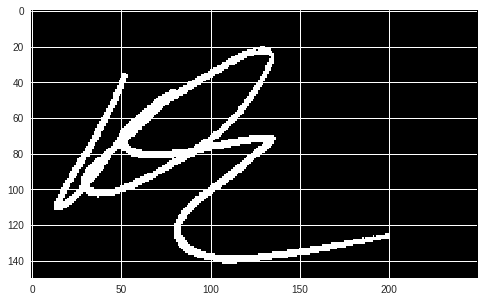

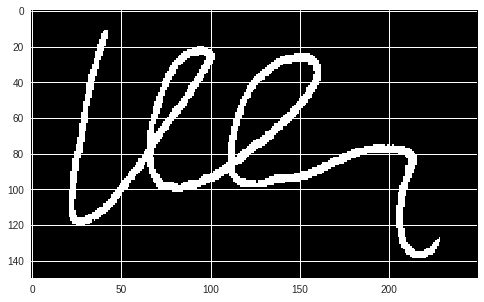

In [61]:
#check for GPU with Keras
from keras import backend as K
device_gpu=K.tensorflow_backend._get_available_gpus()
print device_gpu

#plot images from data in datasets 
image=np.squeeze(np.array(gen[12]),axis=2)
from matplotlib import pyplot as plt
plt.imshow(np.uint8(image))
plt.show()

image=np.squeeze(np.array(forg[12]),axis=2)
plt.imshow(np.uint8(image))
plt.show()

In [62]:

row, col, ch = 150, 250, 1 #image shape input to the 1st layer of the CNN
num_classes=44             #number of people whose signatures have been sampled

# Build a neural network in Keras

from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Dropout, Flatten, Lambda, ELU, Activation, Conv2D, BatchNormalization, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# CNN model - Building the model suggested in DeepWriter paper (handwriting recognition model)

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(1024, name='dense1')) 

model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, name='dense2'))  
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_8 (ZeroPaddin (None, 152, 252, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 76, 126, 32)       832       
_________________________________________________________________
activation_43 (Activation)   (None, 76, 126, 32)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 38, 63, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 38, 63, 64)        18496     
_________________________________________________________________
activation_44 (Activation)   (None, 38, 63, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 19, 31, 64)        0         
__________

In [63]:
#train the model
model.fit(x=np.array(gen),y=np.array(Ygen),epochs=50,batch_size=5,verbose=1)
!rm 'drive/Colab/deepwriter.h5'
model.save('drive/Colab/deepwriter.h5')

Epoch 1/50
220/220 [==============================] - 3s 15ms/step - loss: 3.8191 - acc: 0.0000e+00
Epoch 2/50
220/220 [==============================] - 1s 7ms/step - loss: 3.7097 - acc: 0.0000e+00
Epoch 3/50
220/220 [==============================] - 2s 7ms/step - loss: 3.5352 - acc: 0.0227
Epoch 4/50
220/220 [==============================] - 1s 7ms/step - loss: 3.3952 - acc: 0.0227
Epoch 5/50
220/220 [==============================] - 1s 7ms/step - loss: 3.3003 - acc: 0.0409
Epoch 6/50
220/220 [==============================] - 1s 7ms/step - loss: 3.2952 - acc: 0.0227
Epoch 7/50
220/220 [==============================] - 1s 7ms/step - loss: 3.3410 - acc: 0.0318
Epoch 8/50
220/220 [==============================] - 1s 7ms/step - loss: 2.9626 - acc: 0.1136
Epoch 9/50
220/220 [==============================] - 2s 7ms/step - loss: 2.4009 - acc: 0.2545
Epoch 10/50
220/220 [==============================] - 1s 7ms/step - loss: 2.0450 - acc: 0.3545
Epoch 11/50
220/220 [===================

In [64]:
!ls "drive/Colab"
model_dw = load_model('drive/Colab/deepwriter.h5') #load the model from .h5 file then predict

dataset1	   dataset_genuine.h5  signature_recognition_softmax.ipynb
dataset2	   deepwriter.h5       signature_verification_siamese.ipynb
dataset4	   forged
dataset_forged.h5  genuine


In [65]:
#check model performance on test set of the original training set
preds = model_dw.evaluate(x=np.array(gen),y=np.array(Ygen))
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

220/220 [==============================] - 0s 2ms/step
Loss = 0.25612028783017937
Test Accuracy = 0.8500000021674416


In [44]:
#now check model performance on test set of forged image (performance is significantly worse than genuine image dataset)
preds = model_dw.evaluate(x=np.array(forg),y=np.array(Yforg))
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 595us/step
Loss = 3.1090720748901366
Test Accuracy = 0.43333333253860473


In [66]:
#check model prediction output
imgarr1=np.array([gen[7]]) #first on genuine image, predicts it is signer 2 with probability 0.99, accuracy 99%
print imgarr1.shape
model.predict(imgarr1)

(1, 150, 250, 1)


array([[2.0967431e-07, 9.9990940e-01, 8.7508015e-06, 4.5613074e-06,
        6.1927976e-06, 3.8629717e-09, 4.3859100e-06, 3.2652005e-07,
        9.7760733e-09, 7.4948314e-09, 1.0695282e-08, 4.0923402e-07,
        4.8204174e-06, 1.2045351e-05, 1.1256056e-08, 1.4499967e-09,
        7.0211912e-09, 3.9437822e-07, 1.4596183e-07, 1.7149094e-09,
        5.1941726e-09, 2.5028524e-07, 1.2593038e-08, 7.2614043e-06,
        2.8937745e-08, 1.0309833e-07, 3.7536900e-08, 2.6467390e-08,
        4.7933685e-07, 1.2854126e-07, 2.6045228e-08, 1.1044231e-06,
        2.3826503e-06, 8.0929908e-08, 3.8002670e-06, 3.9561965e-06,
        1.6637150e-06, 3.7962280e-08, 1.6783675e-05, 3.7101299e-07,
        5.8488367e-06, 8.1234059e-09, 3.6559500e-06, 9.1076849e-08]],
      dtype=float32)

In [67]:
imgarr2=np.array([forg[7]]) #now on forged image, it could be signer 2 with probability 0.000147 or 0.0147% accuracy
model.predict(imgarr2)

array([[0.01593518, 0.01610649, 0.01106168, 0.0285084 , 0.01607984,
        0.00637525, 0.07516012, 0.20341463, 0.00967834, 0.00518187,
        0.00481057, 0.00376829, 0.03128962, 0.00935899, 0.03380511,
        0.00763422, 0.00218052, 0.00273697, 0.00125659, 0.00533457,
        0.1373312 , 0.00350263, 0.00169925, 0.02236702, 0.01061536,
        0.0082765 , 0.00382742, 0.00137452, 0.0018636 , 0.00323991,
        0.00212704, 0.01065231, 0.03321296, 0.01330751, 0.00835678,
        0.04386236, 0.01458969, 0.0023645 , 0.0036557 , 0.04040543,
        0.10435002, 0.00476764, 0.03153659, 0.00303688]], dtype=float32)

In [68]:
#display prediction probabilities on genuine image set (training set) dataset 3 + 4 real signatures
prediction_gen=[]
probabilities_gen=[]
for i in range(220):
    imgarr=np.array([gen[i]])
    a=model_dw.predict(imgarr)
    for i in range(len(a[0])):
        if a[0][i]>10**(-2):
            prediction_gen.append(i)
            probabilities_gen.append(a[0][i])
            break

for i in range(220):
    print "Filename:",genfilelist[i],"Signer number:",prediction_gen[i]+1,"with probability:",probabilities_gen[i]



Filename: drive/Colab/genuine/NFI-00101001.png Signer number: 1 with probability: 0.6063844
Filename: drive/Colab/genuine/NFI-00102001.png Signer number: 1 with probability: 0.57397395
Filename: drive/Colab/genuine/NFI-00103001.png Signer number: 1 with probability: 0.52531797
Filename: drive/Colab/genuine/NFI-00104001.png Signer number: 1 with probability: 0.59174854
Filename: drive/Colab/genuine/NFI-00105001.png Signer number: 1 with probability: 0.5967557
Filename: drive/Colab/genuine/NFI-00201002.png Signer number: 2 with probability: 0.9995134
Filename: drive/Colab/genuine/NFI-00202002.png Signer number: 2 with probability: 0.99988735
Filename: drive/Colab/genuine/NFI-00203002.png Signer number: 2 with probability: 0.9999094
Filename: drive/Colab/genuine/NFI-00204002.png Signer number: 2 with probability: 0.9998877
Filename: drive/Colab/genuine/NFI-00205002.png Signer number: 2 with probability: 0.99976605
Filename: drive/Colab/genuine/NFI-00301003.png Signer number: 1 with probab

In [70]:
#display prediction probabilities on forged image set (test set) if fraud was not detected it would match the above output
prediction_forg=[]
probabilities_forg=[]
for i in range(150):
    imgarr=np.array([forg[i]])
    a=model_dw.predict(imgarr)
    for i in range(len(a[0])):
        if a[0][i]>10**(-2):
            prediction_forg.append(i)
            probabilities_forg.append(a[0][i])
            break
            
for i in range(150):
    print "Filename:",forgfilelist[i],"Signer number: ",prediction_forg[i]+1,"with probability: ",probabilities_forg[i]
    

Filename: drive/Colab/forged/NFI-00301001.png Signer number:  1 with probability:  0.0120014325
Filename: drive/Colab/forged/NFI-00302001.png Signer number:  5 with probability:  0.13741791
Filename: drive/Colab/forged/NFI-00303001.png Signer number:  1 with probability:  0.019138204
Filename: drive/Colab/forged/NFI-00304001.png Signer number:  1 with probability:  0.061316162
Filename: drive/Colab/forged/NFI-00305001.png Signer number:  1 with probability:  0.02711458
Filename: drive/Colab/forged/NFI-00301002.png Signer number:  2 with probability:  0.2795289
Filename: drive/Colab/forged/NFI-00302002.png Signer number:  2 with probability:  0.9794074
Filename: drive/Colab/forged/NFI-00303002.png Signer number:  1 with probability:  0.015935177
Filename: drive/Colab/forged/NFI-00304002.png Signer number:  1 with probability:  0.036146156
Filename: drive/Colab/forged/NFI-00305002.png Signer number:  2 with probability:  0.7558193
Filename: drive/Colab/forged/NFI-00401003.png Signer numb

In [0]:
#check predictions on dataset 1 real signatures
filenamelist=[]
prediction_ds1real=[]
probabilities_ds1real=[]
files=0
ds1real=[]
for filename in os.listdir("drive/Colab/dataset1/real"):
        files=files+1
        filenamelist.append(filename)
        filepath="drive/Colab/dataset1/real/"+filename
        #print filepath
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap = cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)  #resize the image to manage the computational complexity in training
        pixelmap = np.expand_dims(pixelmap, axis=2) #to map it to ML model input
        pixelmap=pixelmap/255
        ds1real.append(np.asarray(pixelmap))
        #print pixelmap.shape
        a=model_dw.predict(np.array([pixelmap]))
        for i in range(len(a[0])):
            if a[0][i]>10**(-2):
                prediction_ds1real.append(i)
                probabilities_ds1real.append(a[0][i])
                break
print ("Files=",files)
for i in range(files):
        print "Filename:",filenamelist[i],"Signer number: ",prediction_ds1real[i]+1,"with probability: ",probabilities_ds1real[i]
    


In [52]:
#check predictions on dataset 2 real signatures
filenamelist=[]
prediction_ds2real=[]
probabilities_ds2real=[]
files=0
for filename in os.listdir("drive/Colab/dataset2/real"):
        files=files+1
        filenamelist.append(filename)
        filepath="drive/Colab/dataset2/real/"+filename
        #print filepath
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap = cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)  #resize the image to manage the computational complexity in training
        pixelmap = np.expand_dims(pixelmap, axis=2) #to map it to ML model input
        pixelmap=pixelmap/255
        #print pixelmap.shape
        a=model_dw.predict(np.array([pixelmap]))
        for i in range(len(a[0])):
            if a[0][i]>10**(-2):
                prediction_ds2real.append(i)
                probabilities_ds2real.append(a[0][i])
                break
print ("Files=",files)
for i in range(files):
        print "Filename:",filenamelist[i],"Signer number: ",prediction_ds2real[i]+1,"with probability: ",probabilities_ds2real[i]

 Filename: 00903009.png Signer number:  1 with probability:  0.011625964
Filename: 01204012.png Signer number:  1 with probability:  0.06546845
Filename: 00302003.png Signer number:  28 with probability:  0.9991953
Filename: 00805008.png Signer number:  1 with probability:  0.09680162
Filename: 00901009.png Signer number:  7 with probability:  0.021566175
Filename: 00703007.png Signer number:  25 with probability:  0.9993567
Filename: 00603006.png Signer number:  25 with probability:  0.9998024
Filename: 01102011.png Signer number:  1 with probability:  0.14957568
Filename: 01002010.png Signer number:  3 with probability:  0.010371678
Filename: 00702007.png Signer number:  25 with probability:  0.99799204
Filename: 01105011.png Signer number:  1 with probability:  0.41761458
Filename: 00405004.png Signer number:  29 with probability:  0.9998104
Filename: 00401004.png Signer number:  29 with probability:  0.9990773
Filename: 00503005.png Signer number:  30 with probability:  0.9999579
F

In [54]:
#check predictions on dataset 4 real signatures
filenamelist=[]
prediction_ds4real=[]
probabilities_ds4real=[]
files=0
for filename in os.listdir("drive/Colab/dataset4/real"):
        files=files+1
        filenamelist.append(filename)
        filepath="drive/Colab/dataset4/real/"+filename
        #print filepath
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap = cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)  #resize the image to manage the computational complexity in training
        pixelmap = np.expand_dims(pixelmap, axis=2) #to map it to ML model input
        pixelmap=pixelmap/255
        #print pixelmap.shape
        a=model_dw.predict(np.array([pixelmap]))
        for i in range(len(a[0])):
            if a[0][i]>10**(-2):
                prediction_ds4real.append(i)
                probabilities_ds4real.append(a[0][i])
                break
print ("Files=",files)
for i in range(files):
        print "Filename:",filenamelist[i],"Signer number: ",prediction_ds4real[i]+1,"with probability: ",probabilities_ds4real[i]

90
Filename: 09203092.png Signer number:  13 with probability:  0.6927207
Filename: 00201002.png Signer number:  2 with probability:  0.9999968
Filename: 09301093.png Signer number:  44 with probability:  0.9998934
Filename: 03302033.png Signer number:  31 with probability:  0.9989097
Filename: 04604046.png Signer number:  1 with probability:  0.54560506
Filename: 01602016.png Signer number:  2 with probability:  0.015262552
Filename: 00202002.png Signer number:  2 with probability:  0.99999297
Filename: 01605016.png Signer number:  5 with probability:  0.28200793
Filename: 06302063.png Signer number:  3 with probability:  0.5099514
Filename: 06301063.png Signer number:  3 with probability:  0.523673
Filename: 08505085.png Signer number:  40 with probability:  0.9998217
Filename: 03502035.png Signer number:  5 with probability:  0.48033583
Filename: 09303093.png Signer number:  44 with probability:  0.99830014
Filename: 09302093.png Signer number:  44 with probability:  0.9999676
Filen

In [55]:
#check predictions on dataset 1 forged signatures
filenamelist=[]
prediction_ds1forg=[]
probabilities_ds1forg=[]
files=0
for filename in os.listdir("drive/Colab/dataset1/forge"):
        files=files+1
        filenamelist.append(filename)
        filepath="drive/Colab/dataset1/forge/"+filename
        #print filepath
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap = cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)  #resize the image to manage the computational complexity in training
        pixelmap = np.expand_dims(pixelmap, axis=2) #to map it to ML model input
        pixelmap=pixelmap/255
        #print pixelmap.shape
        a=model_dw.predict(np.array([pixelmap]))
        for i in range(len(a[0])):
            if a[0][i]>10**(-2):
                prediction_ds1forg.append(i)
                probabilities_ds1forg.append(a[0][i])
                break
print ("Files=",files)
for i in range(files):
        print "Filename:",filenamelist[i],"Signer number: ",prediction_ds1forg[i]+1,"with probability: ",probabilities_ds1forg[i]

60
Filename: 02103002.png Signer number:  9 with probability:  0.6079553
Filename: 02103003.png Signer number:  10 with probability:  0.95814264
Filename: 02101012.png Signer number:  9 with probability:  0.0114750555
Filename: 02101007.png Signer number:  14 with probability:  0.046599593
Filename: 02101006.png Signer number:  6 with probability:  0.16677403
Filename: 02101011.png Signer number:  6 with probability:  0.015728973
Filename: 02101005.png Signer number:  6 with probability:  0.03632302
Filename: 02101010.png Signer number:  16 with probability:  0.94915575
Filename: 02103001.png Signer number:  6 with probability:  0.11036306
Filename: 02101004.png Signer number:  17 with probability:  0.05073467
Filename: 02104008.png Signer number:  16 with probability:  0.98798114
Filename: 02104009.png Signer number:  11 with probability:  0.017255375
Filename: 02103004.png Signer number:  14 with probability:  0.9870279
Filename: 02103012.png Signer number:  9 with probability:  0.10

In [56]:
#check predictions on dataset 2 forged signatures
filenamelist=[]
prediction_ds2forg=[]
probabilities_ds2forg=[]
files=0
for filename in os.listdir("drive/Colab/dataset2/forge"):
        files=files+1
        filenamelist.append(filename)
        filepath="drive/Colab/dataset2/forge/"+filename
        #print filepath
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap = cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)  #resize the image to manage the computational complexity in training
        pixelmap = np.expand_dims(pixelmap, axis=2) #to map it to ML model input
        pixelmap=pixelmap/255
        #print pixelmap.shape
        a=model_dw.predict(np.array([pixelmap]))
        for i in range(len(a[0])):
            if a[0][i]>10**(-2):
                prediction_ds2forg.append(i)
                probabilities_ds2forg.append(a[0][i])
                break
print ("Files=",files)
for i in range(files):
        print "Filename:",filenamelist[i],"Signer number: ",prediction_ds2forg[i]+1,"with probability: ",probabilities_ds2forg[i]

60
Filename: 02101007.png Signer number:  1 with probability:  0.010878075
Filename: 02101005.png Signer number:  1 with probability:  0.09128774
Filename: 02101006.png Signer number:  1 with probability:  0.08855157
Filename: 02103003.png Signer number:  1 with probability:  0.022364957
Filename: 02104009.png Signer number:  3 with probability:  0.01625614
Filename: 02101011.png Signer number:  1 with probability:  0.45327774
Filename: 02101004.png Signer number:  5 with probability:  0.100468084
Filename: 02101012.png Signer number:  1 with probability:  0.028602012
Filename: 02202010.png Signer number:  5 with probability:  0.1537229
Filename: 02104008.png Signer number:  1 with probability:  0.041808758
Filename: 02103004.png Signer number:  1 with probability:  0.15808527
Filename: 02202002.png Signer number:  27 with probability:  0.99463934
Filename: 02103011.png Signer number:  1 with probability:  0.21717142
Filename: 02204010.png Signer number:  1 with probability:  0.0231399

In [57]:
#check predictions on dataset 4 forged signatures
filenamelist=[]
prediction_ds4forg=[]
probabilities_ds4forg=[]
files=0
for filename in os.listdir("drive/Colab/dataset4/forge"):
        files=files+1
        filenamelist.append(filename)
        filepath="drive/Colab/dataset4/forge/"+filename
        #print filepath
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        pixelmap=np.asarray(img)
        #print pixelmap.shape
        pixelmap = cv2.resize(pixelmap,(250,150),interpolation= cv2.INTER_AREA)  #resize the image to manage the computational complexity in training
        pixelmap = np.expand_dims(pixelmap, axis=2) #to map it to ML model input
        pixelmap=pixelmap/255
        #print pixelmap.shape
        a=model_dw.predict(np.array([pixelmap]))
        for i in range(len(a[0])):
            if a[0][i]>10**(-2):
                prediction_ds4forg.append(i)
                probabilities_ds4forg.append(a[0][i])
                break

print ("Files=",files)
                
for i in range(files):
        print "Filename:",filenamelist[i],"Signer number: ",prediction_ds4forg[i]+1,"with probability: ",probabilities_ds4forg[i]

('Files=', 90)
Filename: 00302046.png Signer number:  2 with probability:  0.024410136
Filename: 06104071.png Signer number:  1 with probability:  0.016240845
Filename: 02304070.png Signer number:  1 with probability:  0.01315842
Filename: 00301002.png Signer number:  41 with probability:  0.9997181
Filename: 03205084.png Signer number:  30 with probability:  0.08166135
Filename: 02303093.png Signer number:  3 with probability:  0.011312197
Filename: 01605033.png Signer number:  1 with probability:  0.010158934
Filename: 00403063.png Signer number:  1 with probability:  0.06767812
Filename: 03205086.png Signer number:  2 with probability:  0.6730733
Filename: 03205085.png Signer number:  1 with probability:  0.055679776
Filename: 00304035.png Signer number:  1 with probability:  0.019650014
Filename: 00404044.png Signer number:  1 with probability:  0.02968343
Filename: 00404092.png Signer number:  1 with probability:  0.016489457
Filename: 01604077.png Signer number:  13 with probabil